In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## Preliminary Approach: CNN Baseline
---

Use a CNN by treating the problem as a classification task between 37 classes (0-36)

In [27]:

# Load data
img_data_1 = np.load('data1.npy')
img_data_0 = np.load('data0.npy')
img_data_2 = np.load('data2.npy')

img_label1 = np.load('lab1.npy')
img_label0 = np.load('lab0.npy')
img_label2 = np.load('lab2.npy')

# Concatenate all data
all_data = np.concatenate([img_data_0, img_data_1, img_data_2])

# Concatenate all labels
all_labels = np.concatenate([img_label0, img_label1, img_label2])


# Split into train (80%) and temp (20%) datasets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42)

# Split temp into validation (10% of total) and test (10% of total) datasets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)


# Convert to PyTorch tensors and add channel dimension
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)  # Shape: [num_samples, 1, 40, 168]
val_data_tensor = torch.tensor(val_data, dtype=torch.float32).unsqueeze(1)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
class CNNClassifier(nn.Module):

    def __init__(self):
        super(CNNClassifier, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 5 * 21, out_features=512)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=512, out_features=37)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 5 * 21)
        
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [29]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Instantiate the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

Using device: cuda


In [36]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    correct_val = 0
    total_val = 0
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0

        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Validation Accuracy: 10.30%
Epoch [1/10], Train Loss: 0.6538, Val Loss: 5.1098
Early stopping at epoch 1


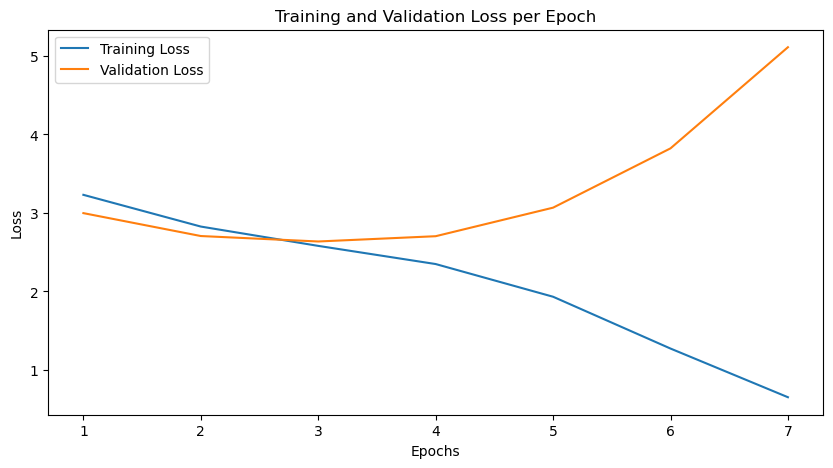

In [37]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# Evaluation on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 11.27%
